==============================================================================================
# Practicum 6 

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P6_Student1_Student2.zip** that includes:
    - The notebook P6_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline: December 22th, 23:00 h**

==============================================================================================

## Imports

In [1]:
from time import time
import os

import numpy as np
from numpy import unique
import matplotlib.pyplot as plt

import skimage
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import io

# Split dataset into training and test
from sklearn.model_selection import train_test_split 

### FACE DETECTION
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from skimage.transform import integral_image

### FACE RECOGNITION
# Load the dataset
from sklearn.datasets import fetch_lfw_people 
# Classification and results
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report 

In [2]:
# Show images
def show_images(m, n, imgs, labels):
    fig, axes = plt.subplots(m, n, figsize=(13, 6))
    ax = axes.ravel()
    cmap='gray'
    for i in range(m*n):
        ax[i].imshow(imgs[i], cmap)
        ax[i].set_title(labels[i])
        ax[i].axis('off')
        
    plt.tight_layout()
    plt.show()

==============================================================================================
## Haar-like features applied for face detection
==============================================================================================

### What is a Haar-like feature?

Haar-like feature descriptors were successfully used to implement the first real-time face detector. In this laboratory we will see an example illustrating the extraction, selection, and classification of Haar-like features to detect faces vs. non-faces.

Documentation [Haar-like feature skimage](https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_haar_extraction_selection_classification.html)

Haar-like features are features extracted from the images to recognize objects. These features are normally used in face recognition. The key to face recognition is to detect the relevant features of humans such as eyes, lips, or nose. 


<img src="notebook_images/haar-like.PNG" width=400, height=400>

Try to guess where in the face image we expect to detect an edge, line or another facial feature and what would be the most appropriate Haar-feature for them? 

<img src="notebook_images/haar-like1.PNG" width=500, height=500>


A real application would be:

<img src="notebook_images/face.PNG" width=300, height=300>


To describe the face, we can apply convolutions with Haar features. What alternative to the convolution with Haar-features, do you know?


### 1. Building integral image

Compute all the Haar-like features (we can define up to 16000 million masks), can be a slow process. To compute it faster, we are going to use the integral images (instead of convolutions). It is very useful because we are able to save all the sums and substrations of image rectangles to avoid computing all the features every time.

When creating an Integral Image, we need to create a Summed Area Table. What does represent any point (x,y) in this table?

<img src="notebook_images/integral_image.PNG" width=250, height=2500>

An example :

<img src="notebook_images/integral_image1.PNG" width=400, height=400>

To easy the computation of Haar features, the integral image must have an additional row and column full of zeros (first row and first column). Why?

**1.1** Build a function `to_integral_image` that computes the integral image of an input (2D) array. The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

Try your function using a `5x5` random grayscale image. Visualize both the original random image and the integral one.

In [3]:
def to_integral_image(img_arr):
    """
    Calculates the integral image based on this instance's original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    #row and columns of zeros added
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))
    integral_image_arr[1:,1:]= img_arr
    
    for i in range(1, integral_image_arr.shape[0]):
        for j in range(1, integral_image_arr.shape[1]):
            integral_image_arr[i,j] = np.sum(img_arr[:i,:j]) 
    
    return integral_image_arr

To make sure that the values of the integral image are correct, compute the following tests:

 - `img_array.sum() == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`

In [4]:
img_array = np.random.randint(2, size=(5,5))
ii_img_array = to_integral_image( img_array )

In [5]:
img_array.sum() == ii_img_array[-1,-1]

True

In [6]:
img_array[0,:].sum() == ii_img_array[1,-1]

True

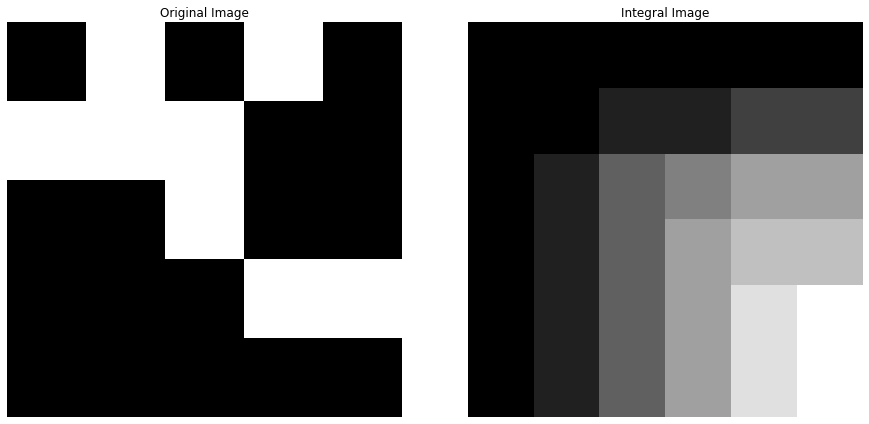

In [7]:
show_images(1, 2, [img_array, ii_img_array], ["Original Image", "Integral Image"])

**1.2** Let's check in real images. Choose an image from the directory ``./faces``, visualize both the original and the integral image, and make the same test that in the previous question.

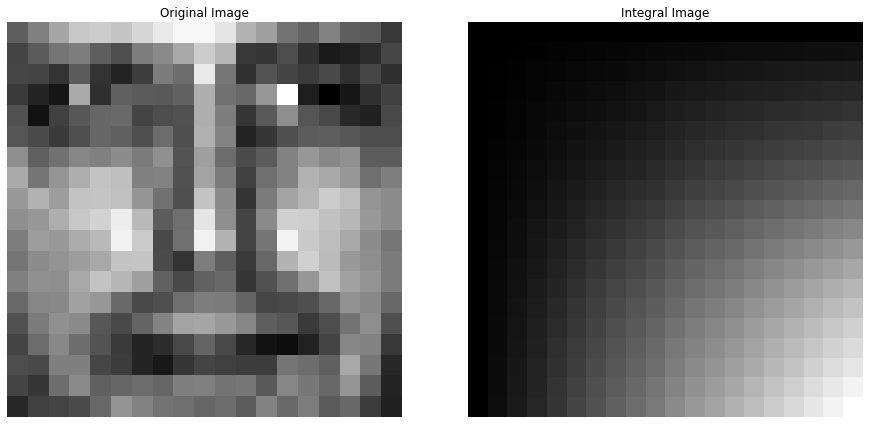

In [8]:
img_ = io.imread('./faces/face00001.png')
integral_ = to_integral_image( img_ )
show_images(1, 2, [img_, integral_], ["Original Image", "Integral Image"])


What do the following lines mean? How can you explain this?

- `img_array.sum() == ii_img_array[-1,-1]`
- `img_array[0,:].sum() == ii_img_array[1,-1]`
- `ii_img_array[0,-1].sum() == 0`
 

The first one means that the last pixel of the image contains the sum of all the image. The second one means that the last position of the first row is the sum of all the elements in its left, because in the row above there are only zeros. And the last one, means that the last position of the first row is a zero because all the elements on the first row are zero.


**1.3:** Alternatively to your own function, you can use the ``integral_image()`` function from ``skimage.transform``. Compare (numerically) the result obtained using your funtion and that obtained using the function provided by skimage.

In [9]:
from skimage.transform import integral_image
integral_sky = integral_image(img_)
res = integral_[1:,1:] - integral_sky
print(res)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

As we can see on the matrix that shows the error, we have obtained the same result because there's no error. We can obtain the error with one number as follows:

In [10]:
mine = to_integral_image(img_)
skim = integral_image(img_)
print('to_integral_image: ',mine.sum(), ', sum of result matrix')
print('integral_image: ',skim.sum(),', sum of result matrix')

to_integral_image:  4250805.0 , sum of result matrix
integral_image:  4250805 , sum of result matrix


## 2. Haar-like features

Let's use the [haar_like_feature()](https://scikit-image.org/docs/0.14.x/api/skimage.feature.html#skimage.feature.haar_like_feature) function from skimage. Check the parameters and the returned value of the ``function haar_like_feature()`` before continuing and **NOTE** that we must use the integral image (**not the real image**) in this function.

*skimage.feature.haar_like_feature(int_image, rint, cint, widthint, heightint, feature_type=None, feature_coord=None)*



###  Extract features

**2.1** Define a function ``extract_feature_image(image, feature_type, feature_coord=None)`` to obtain the Haar-like features, using a given type of features ``feature_types``, from an image. The aim of this function is as simple as to join both `to_integral_image()` and `haar_like_feature()`functions.

Try your function using the choosing image from *1.4*. You should obtain a feature vector. Print the vector shape.

**Note:** You can give an array with a set of feature types to the `haar_like_feature()` function and it will compute all the corresponding features. We **do not** need to give each time only one feature.


In [11]:
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

In [12]:
def extract_feature_image(image, feature_type, feature_coord=None):
    ii = to_integral_image(image)
    features = haar_like_feature(ii, 0, 0, image.shape[0], image.shape[1], feature_type, feature_coord)
    return features

In [13]:
features = extract_feature_image(img_, feature_types)
print("Feature vector:", features)
print("Vector shape: ", features.shape)

Feature vector: [ 0.  0.  0. ... 33. 14.  4.]
Vector shape:  (63666,)


**2.2** Plot a Haar-like feature on an image:

To visualize Haar-like features on an image, we need the fuctions, provided by skimage, ``haar_like_feature_coord()``, which computes the coordinates of Haar-like features, and ``draw_haar_like_feature()``, used to visualize that features.

Before continuing, please, **check the online documentation of the two functions**

- [*haar_like_feature_coord(width, height, feature_type=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.haar_like_feature_coord)

- [*draw_haar_like_feature(image, r, c, width, height, feature_coord, color_positive_block=(1.0, 0.0, 0.0), color_negative_block=(0.0, 1.0, 0.0), alpha=0.5, max_n_features=None, random_state=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.draw_haar_like_feature)

Define a function ``plotFeatures``  to visualize Haar-like features on an images, given a array of feature types ``feature_types``. The aim of this exercise is, similarly to the previous one, to merge both `haar_like_feature_coord()` and `draw_haar_like_feature()` functions. Try your own function using the choosing image from *1.4* as follows:

<img src="notebook_images/image1.png" width=600, height=300>

In [14]:
def plotFeatures(img, feature_types):
    imgs = []
    
    for i in feature_types:
        feature_coord, _ = skimage.feature.haar_like_feature_coord(img.shape[0], img.shape[1], i)
        image = skimage.feature.draw_haar_like_feature(img, 0, 0, img.shape[0], img.shape[1], feature_coord, 
                                                       max_n_features=1, random_state=0)
        imgs.append(image)
        
    show_images(1, 5, imgs, feature_types)


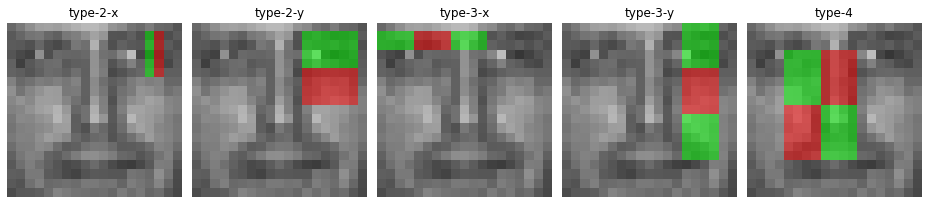

In [15]:
plotFeatures(img_, feature_types)

## 3 Face detection using an Adaboost

**3.1** Read all the images from the directories ``./faces`` and ``./nonfaces`` and build an array with the all the features. 

Futhermore, build the class labels vector ``y`` with the label of all the images

In [16]:
# Build a vector with the faces features
path = "./faces/"                       
face_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

features_faces = []

features_faces = [(extract_feature_image(image, feature_types)) for image in face_images]


In [17]:
print(len(features_faces[0]))

63666


In [18]:
# Build a vector with the non-faces features
path = "./nonfaces/"                       
non_face_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

non_features_faces = []

non_features_faces = [(extract_feature_image(image, feature_types)) for image in non_face_images]

In [19]:
X = np.array(features_faces + non_features_faces)
y = np.array(np.concatenate((np.zeros(len(features_faces)), np.ones(len(non_features_faces))))) # Labels face = 1, non face = 0

In [20]:
print(X.shape)
print(y.shape)

(68, 63666)
(68,)


**3.2** Using the ``train_test_split()`` function from `sklearn.model_selection`, divide the dataset into *train* and *test* sets. The test size must be the 30% (i.e. 0.3) of the whole dataset.

[*sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(47, 63666)
(21, 63666)
(47,)
(21,)


**3.3** Train an Adaboost classifier using `AdaBoostClassifier()`from `sklearn.ensemble`.

[*sklearn.ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1.0)*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

What is an Adaboost? How it works?

In [23]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
clf.fit(X_train, y_train)

AdaBoostClassifier()

**3.4** Evaluate the accuracy of the Adaboost classifier using the *predict* and *score* methods of the classifier. What are these methods doing?

In [24]:
result = clf.predict(X_test)
acc = clf.score(X_test, y_test)
print("Result: ", result)
print("Accuracy: ", acc)


Result:  [1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1.]
Accuracy:  0.9523809523809523


Change the parameter ``n_estimators`` and see what happens. Does it improve?

In [25]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.0)
clf.fit(X_train, y_train)

result = clf.predict(X_test)
acc = clf.score(X_test, y_test)
print("Result: ", result)
print("Accuracy: ", acc)


Result:  [1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1.]
Accuracy:  0.9047619047619048


R: Yes, the accuracy has improved.

**3.5** The method ``feature_importances_`` of the Adaboost is giving the importance of the features. Implement a function to visualize the 10 most important features on an image of a face on your choice. 

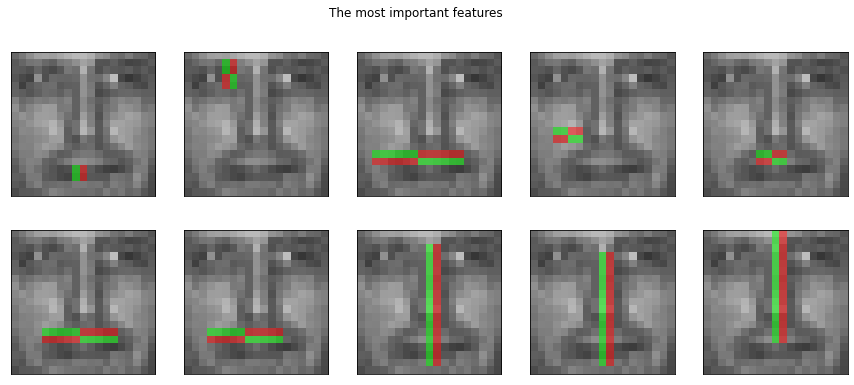

In [26]:
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, axes = plt.subplots(2, 5, figsize=(15,6))
img = io.imread('./faces/face00001.png')
feature_coord, _ = skimage.feature.haar_like_feature_coord(img.shape[0], img.shape[1], feature_types)

for idx, ax in enumerate(axes.ravel()):
    img = face_images[0]
    image = draw_haar_like_feature(img, 0, 0,
                                   img.shape[0],
                                   img.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features')

**3.6 (Optional)** Implement the Adaboost training the model using a different number of features. For instace,  just using 1 type of feature, 2 types, and 3 types. Plot the results comparing the precision. Draw conclusions about the results

In [27]:
#your solution


==============================================================================================
## Principal Component Analysis (PCA) applied for face recognition
==============================================================================================

### Dimensionality and redundancy

Imagine we have a dataset with 100x100 pixel images, it means we have 10000 dimensions. We want to construct a low-dimensional linear subspace that best explains the variation in the set of face images (**Eigenfaces space**)

<img src="notebook_images/subspace.PNG" width=200, height=200>

Each image has m rows and n columns and defines a vector of (mxn) elements. We need to choose the most valuable pixels in order to avoid compute all dimensions. 

<img src="notebook_images/feature_vector.PNG" width=800, height=400>

We look for a transformation of the original space to a smaller (M << (mxn)) where faces are represented with their coordinates in this new space R.

To reduce the dimensionality retaining the information necessary to classify and recognize, we are going to use the **Eigenfaces method** 

### How to build a reduced space?

To build this new space, we are going to use the **Principal Component Analysis**. Given a large space, the PCA looks for the minimum number of axes that best represents the variation of the data.

<img src="notebook_images/pca.PNG" width=400, height=400>

The eigenvectors of the covariance matrix define the axis of maximum variance and the eigenvalues give a measure of the variance of the data. 

1. Construct the vector in the (m x n)-dimensional space R given M images of size (m x n).

2. Compute the mean image 

<center>
$\overline{X}=\frac{1}{M}\sum_{i=1}^{M} X_i$
</center>

3. Construct the covariance matrix. Due to $A \times A^T$ is too large, instead of using $A \times A^T$ to compute its eigenvectors, we are going to compute the eigenvectors of $A^T \times A$.

<img src="notebook_images/covariance_image.PNG" width=500, height=500>

4. Extract the eigenvectors (the base of the new space) and their eigenvalues and project faces in the new space to apply the classifier (knn)


## 4. Load and prepare data

Let's use the [Labeled Faces in the Wild (LFW)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) people dataset (classification).

Face dataset features:

- Classes: 5749

- Samples total: 13233

- Dimensionality: 5828

- Features: real, between 0 and 255


*sklearn.datasets.fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)*



*Please, check the parameters and returned value by ``lethc_lfw_people()`` before continuing.*

**4.1** Load the dataset, obtaining only those cases where there are, at least, 100 images. Check the final number of images, image shapes and labels of the images.

In [28]:
# Load the dataset
from sklearn.datasets import fetch_lfw_people 
dataset = fetch_lfw_people(min_faces_per_person=100)

# We will use these variables later on the seventh section
_, h, w = dataset.images.shape

In [29]:
print("Number of images:", dataset['images'].shape[0])
print("Shape of images:", dataset['images'].shape[1:])
print("Labels:",  dataset['target'])
target_names = dataset.target_names
print("Target names:", target_names)

Number of images: 1140
Shape of images: (62, 47)
Labels: [2 3 1 ... 4 2 4]
Target names: ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


**4.2** Plot an image frome each example, with its name as the title of the image.

<img src="notebook_images/example.png" width=500, height=500>

In [30]:
# Function to show a number of images with determinated labels
def show_images(m, n, imgs, labels):
    fig, axes = plt.subplots(m, n, figsize=(13, 6))
    ax = axes.ravel()
    cmap='gray'
    for i in range(m*n):
        ax[i].imshow(imgs[i], cmap)
        ax[i].set_title(labels[i])
        ax[i].axis('off')
        
    plt.tight_layout()
    plt.show()

In [31]:
results = []
for i in range(5):
    res = np.where(dataset['target'] == i)
    results.append(dataset['images'][res[0][0]])

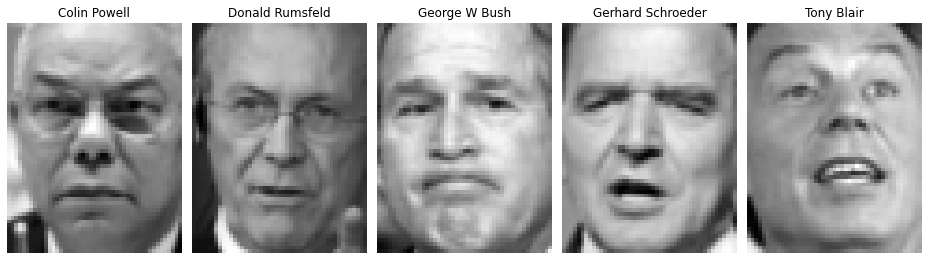

In [32]:
show_images(1, 5,
            results, 
            target_names)

**4.3** Divide the dataset into train and test set (0.7/0.3). 

Hint: use the train_test_split function.

In [33]:
# Split dataset into training and test
from sklearn.model_selection import train_test_split 

x = dataset.data
y = dataset.target
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3)


## 5. Compute PCA

[*class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

The principal components measure deviations about this mean along orthogonal axes.

**5.1** Create a PCA object, using the training set and a 150 components

In [34]:
# Principal component analysis
from sklearn.decomposition import PCA

n_components = 150
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)


Plot the accumated variance of the components. 

**Hint:** Use the returned `explained_variance_ratio_`.

Accumulated variance: 0.953406


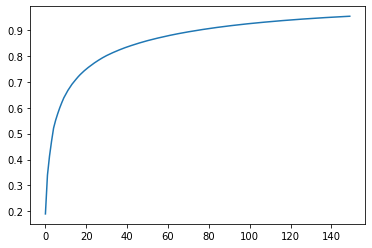

In [35]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
print("Accumulated variance:", np.max(np.cumsum(pca.explained_variance_ratio_)))


**5.2** One interesting part of PCA is that it computes the average face, which can be interesting to examine. 

Plot the average face, using the method `mean_` of the PCA object.

**Hint:** The average face need to be reshaped in order to visualize it properly

In [36]:
def average_face(pca):
    img = np.reshape(pca.mean_, dataset['images'].shape[1:])
    return img

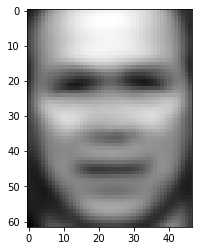

In [37]:
av_face = average_face(pca)
plt.imshow(av_face, cmap='gray')
plt.show()

**5.3** Furhtermore, we can check all the principal components (i.e. eigenfaces) considering the corresponding importance. Visualize 30 principal eigenfaces.

<img src="notebook_images/eigenfaces.png" width=500, height=500>

Note that the base components are ordered by their importance. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc...

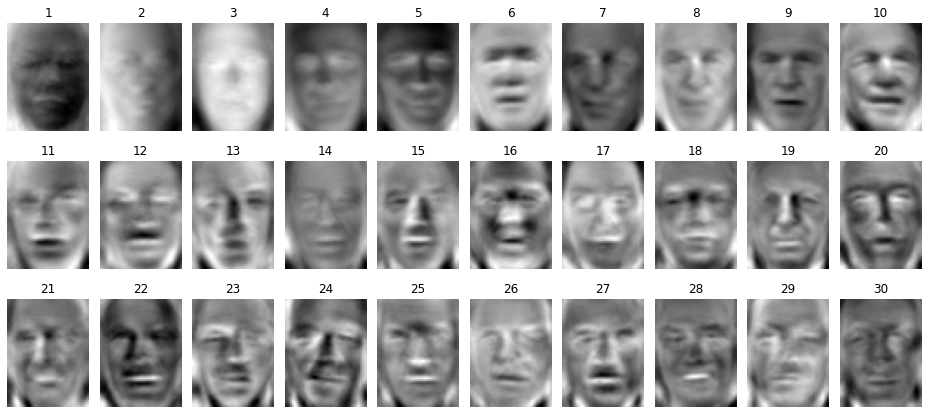

In [38]:
eigenfaces = pca.components_.reshape((n_components, 62, 47))
# Plot the principal 30 eigenfaces
show_images(3,10, eigenfaces[:30], [i for i in range(1,31)])


**5.4** Project both the training and test set onto the PCA basis, using the method `transform()` of the PCA object.

In [39]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Do you need to apply the same to the variable y?

**5.5**  These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face. 

Choose one of the images and try to recompose from its first 10 most important corresponding eigenfaces. **Note that** we need to use the average face as the basis to agregate the rest of the components.


<img src="notebook_images/eigenfaces_image.PNG" width=300, height=300>


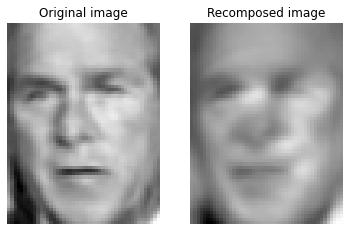

In [40]:
# Target image
image = X_train_pca[0]
face = pca.inverse_transform(image).reshape((h, w))
# Weight image
weights = X_train_pca[0][:10]

# Sort the eigenvectors by their corresponding eigenvalues in decreasing order
indices = np.argsort(pca.explained_variance_)[::-1]
eigenfaces = pca.components_[indices]

# We select the first 10 eigenvectors
eigenfaces = eigenfaces[:10]
eigenfaces /= np.linalg.norm(eigenfaces)

# We use the weights and the first 10 eigenfaces to reconstruct the target image
result = np.dot(weights,eigenfaces)
result += pca.mean_/np.linalg.norm(pca.mean_)
result = result.reshape((h, w))

# Plot the original image
fig, axs = plt.subplots(1, 2)
ax = axs[0]
ax.imshow(face, cmap='gray')
ax.set_title('Original image')
ax.axis('off')

# Plot the recomposed image
ax = axs[1]
ax.imshow(result, cmap='gray')
ax.set_title('Recomposed image')
ax.axis('off')

plt.show()


## 6. Train a classifier

**6.1** Train an Adaboost classifier using the PCA features. Show the results obtained with the test set.
Use the `score` method of the Adaboost model.

In [41]:
from time import time #if I don't import it again, it gives me the error float object is not calleable
t0 = time()

ada_model_pca = AdaBoostClassifier(n_estimators=100, random_state=0)
ada_model_pca.fit(X_train_pca, y_train)

y_pred_pca = ada_model_pca.predict(X_test_pca)

score_pca = ada_model_pca.score(X_test_pca, y_test)

time = time() - t0
print(time)

1.596414566040039


**6.2** We can quantify this effectiveness using one of several measures from sklearn.metrics. First we can do the classification report, which shows the precision, recall and other measures of the “goodness” of the classification.

*sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')*

*Please, check the parameters and returned value by ``classification_report()`` before continuing.*

Print the classification report obtained during the training of the Adaboost model.

In [42]:
# Classification and results
from sklearn.metrics import classification_report 

print(classification_report(y_test, result, target_names=target_names))


ValueError: Found input variables with inconsistent numbers of samples: [342, 62]

Please, explaing what is:
- accuracy (score)
- precision
- recall
- f1-score
- support
- macro avg
- weighted avg?


- Accuracy: Is the mean accuracy on the given test data and labels
- Precision: Is the number of relevant documents retrieved by a search divided by the total number of documents retrieved by that search
- Recall: Is the number of relevant documents retrieved by a search divided by the total number of existing relevant documents.
- F1-score: Is the harmonic mean of the precision and recall
- Support: Is the number of occurrences of each class in y_test
- Macro avg: Averaging the unweighted mean per label
- Weighted avg: Averaging the support-weighted mean per label

**6.3** Train an Adaboost classifier, without PCA, using the training set. Show the results using the `score` method of the Adaboost model and the corresponding classification report.

In [43]:
# Train a Adaboost classifier
from sklearn.ensemble import AdaBoostClassifier
from time import time # If I don't import it again, it gives me the error float object is not calleable
# We use the variable t1 to calculate the execution time
t1 = time()

ada_model = AdaBoostClassifier(n_estimators=100, random_state=0)
ada_model.fit(X_train, y_train)
y_pred = ada_model.predict(X_test)
score = ada_model.score(X_test, y_test)

time = time() - t1
print(time)

23.39447808265686


In [44]:
print('The accuracy of the classifier in the PCA space is: ', score_pca)
print(classification_report(y_test, y_pred, target_names=target_names))

The accuracy of the classifier in the PCA space is:  0.5760233918128655
                   precision    recall  f1-score   support

     Colin Powell       0.62      0.45      0.52        71
  Donald Rumsfeld       0.44      0.19      0.27        36
    George W Bush       0.61      0.85      0.71       159
Gerhard Schroeder       0.57      0.39      0.46        33
       Tony Blair       0.43      0.30      0.36        43

         accuracy                           0.58       342
        macro avg       0.53      0.44      0.46       342
     weighted avg       0.57      0.58      0.56       342



**Questions**

- Does computing time change using PCA? How?
  **R**: The computing time is lower using PCA because of reducing the number of features in the data before training a classifier. This is because classifiers often scale poorly with the number of features, and reducing the number of features can significantly reduce the computation time.
- Which of both (with and without PCA) does give better results?
  **R**: It depends on the dataset and the classifier but using PCA the perfomance may change. In some cases using PCA can reduce sound and improve performance. On the other hand, performance can sometimes decrease using PCA due to loss of information during the dimensionality reduction process.
- How does the result change if we change the number of components in PCA?
  **R**:Performance may change if a different number of components are used. For example, using a larger number results in a larger reconstruction error but also captures more information from the data, gaining better performance. On the other hand, using a smaller number of components, just the opposite occurs, decreasing the reconstruction error but losing information and, therefore, decreasing performance.
- How does the result change if we change the number of estimators in the Adaboost?
   **R**: The performance of the classifier should change if the number of estimators in the AdaBoost is changed. Using a larger number of estimators would create a more complex model that captures more information from the data, increasing performance. Instead using a smaller number of estimators would create a simpler model that may have lower bias but may also have higher variance, potentially resulting in worse performance.

**6.4 (Optional)** Repeat the experiment using a different number of components. 

For instance, instead of using 150 components, try using 10, 25, 50, 200, 500... at your election. These numbers are just orientative. 

- How much variance is acummulated using the different number of components.
- The result is better using... how many components? 
- Does time change using a different numbero of components?

In [45]:
from time import time
t1 = time()

clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.0)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
acc = clf.score(X_test, y_test)
print("Accuracy: ", acc)

time = time() - t1
print("Time: ", time)

Accuracy:  0.5847953216374269
Time:  23.407578945159912


In [46]:
from time import time
t1 = time()

clf = AdaBoostClassifier(n_estimators=10, learning_rate=1.0)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
acc = clf.score(X_test, y_test)
print("Accuracy: ", acc)

time = time() - t1
print("Time: ", time)

Accuracy:  0.5029239766081871
Time:  2.334207057952881


In [47]:
from time import time
t1 = time()

clf = AdaBoostClassifier(n_estimators=25, learning_rate=1.0)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
acc = clf.score(X_test, y_test)
print("Accuracy: ", acc)

time = time() - t1
print("Time: ", time)

Accuracy:  0.5497076023391813
Time:  5.838946104049683


In [48]:
from time import time
t1 = time()

clf = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
acc = clf.score(X_test, y_test)
print("Accuracy: ", acc)

time = time() - t1
print("Time: ", time)

Accuracy:  0.5789473684210527
Time:  11.767322540283203


In [49]:
from time import time
t1 = time()

clf = AdaBoostClassifier(n_estimators=200, learning_rate=1.0)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
acc = clf.score(X_test, y_test)
print("Accuracy: ", acc)

time = time() - t1
print("Time: ", time)

Accuracy:  0.6140350877192983
Time:  47.16249442100525


As we can see, if we decrease the components, the execution time decreases but the accuracy also decreases. On the other hand, if we increase the number of components, both the execution time and the accuracy increase, therefore the objective is to find a intermediate value in which to balance these two aspects to have enough accuracy and a moderate execution time.

For example, with a number of components of 50, it takes less time to execute and has greater accuracy, which is a more balanced value and one that interests us more than not having 100 components.

## 7. Recognize a new face example using the learned model

**7.1** Try your both models using the test set. 

Predict the labels using the Adaboost model, with and without PCA, and plot the images with the corresponding label as title.

<img src="notebook_images/prediction.png" width=300 height = 300>

With PCA


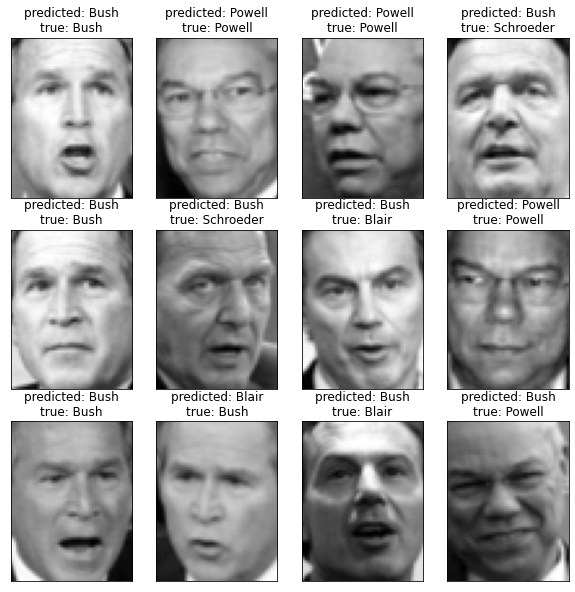

In [50]:
def visualize(images, titles, h, w, rows=3, cols=4):
    plt.figure(figsize=(10,10))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
        
def predict(y_pred, y_test, target_names):
    for i in range(y_pred.shape[0]):
        pred_name = target_names[y_pred[i]].split(' ')[-1]
        true_name = target_names[y_test[i]].split(' ')[-1]
        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)

        
print('With PCA')        
prediction_titles = list(predict(y_pred_pca, y_test, target_names))
visualize(X_test, prediction_titles, h, w)

In [51]:
print('Without PCA')        
prediction_titles = list(predict(y_pred, y_test, names))
visualize(X_test, prediction_titles, h, w)

Without PCA


NameError: name 'names' is not defined

Which model makes the predictions betters? Try different parameters and comment their effect on the model performance.